# Multiclass classification with GPflow

In [1]:
import GPflow
import tensorflow as tf
import matplotlib
import numpy as np
#matplotlib.style.use('ggplot')
%matplotlib inline
plt = matplotlib.pyplot

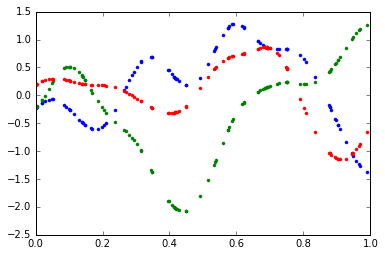

In [2]:
#make a one dimensional classification problem
np.random.seed(1)
X = np.random.rand(100,1)
K = np.exp(-0.5*np.square(X - X.T)/0.01) + np.eye(100)*1e-6
f = np.dot(np.linalg.cholesky(K), np.random.randn(100,3))

plt.plot(X, f, '.')

In [3]:
Y = np.argmax(f, 1).reshape(-1,1)

In [4]:
m = GPflow.svgp.SVGP(X, Y, 
                     kern=GPflow.kernels.Matern32(1) + GPflow.kernels.White(1, variance=0.01),
                     likelihood=GPflow.likelihoods.MultiClass(3),
                     Z=X[::5].copy(), num_latent=3, whiten=True, q_diag=True)

In [5]:
m.kern.white.variance.fixed = True
m.Z.fixed = True
_ = m.optimize()


compiling tensorflow function...
done
optimization terminated, setting model state


In [6]:
def plot(m):
    f = plt.figure()
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])
    
    
    xx = np.linspace(m.X.min(), m.X.max(), 200).reshape(-1,1)
    mu, var = m.predict_f(xx)
    mu, var = mu.copy(), var.copy()
    p, _ = m.predict_y(xx)
    
    a3.set_xticks([])
    a3.set_yticks([])
    
    
    a3.set_xticks([])
    a3.set_yticks([])
    
    for i in range(m.likelihood.num_classes):
        x = m.X[m.Y.flatten()==i]
        points, = a3.plot(x, x*0, '.')
        color=points.get_color()
        a1.plot(xx, mu[:,i], color=color, lw=2)
        a1.plot(xx, mu[:,i] + 2*np.sqrt(var[:,i]), '--', color=color)
        a1.plot(xx, mu[:,i] - 2*np.sqrt(var[:,i]), '--', color=color)
        a2.plot(xx, p[:,i], '-', color=color, lw=2)
    
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])

    

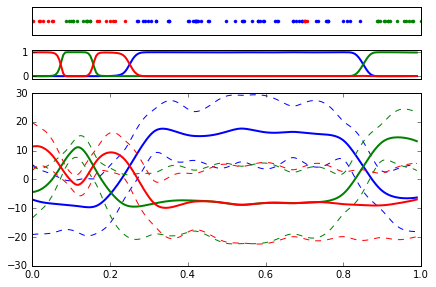

In [7]:
plot(m)

In [8]:
print m.kern

kern.white.variance transform:+ve prior:None [FIXED]
[ 0.01]
kern.matern32.lengthscales transform:+ve prior:None
[ 0.1040372]
kern.matern32.variance transform:+ve prior:None
[ 80.40056701]


In [9]:
m = GPflow.sgpmc.SGPMC(X, Y, 
                     kern=GPflow.kernels.Matern32(1, lengthscales=0.1) + GPflow.kernels.White(1, variance=0.01),
                     likelihood=GPflow.likelihoods.MultiClass(3),
                     Z=X[::5].copy(), num_latent=3)

In [10]:
m.kern.matern32.variance.prior = GPflow.priors.Gamma(1.,1.)
m.kern.matern32.lengthscales.prior = GPflow.priors.Gamma(2.,2.)
m.kern.white.variance.fixed = True

In [11]:
_ = m.optimize(max_iters=10)

compiling tensorflow function...
done
optimization terminated, setting model state


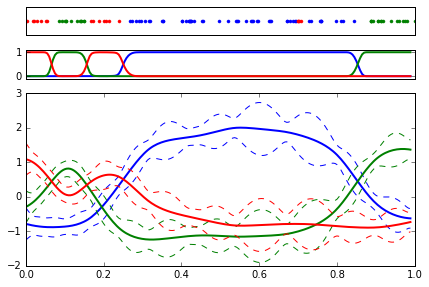

In [12]:
plot(m)

In [13]:
samples = m.sample(500, verbose=True, epsilon=0.04, Lmax=15)

Iteration:  100 	 Acc Rate:  71.0 %
Iteration:  200 	 Acc Rate:  66.0 %
Iteration:  300 	 Acc Rate:  51.0 %
Iteration:  400 	 Acc Rate:  30.0 %
Iteration:  500 	 Acc Rate:  40.0 %


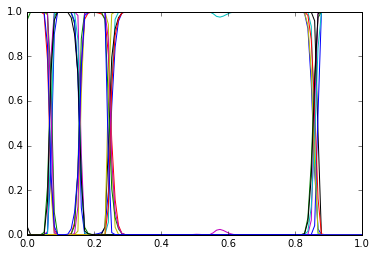

In [14]:
xx = np.linspace(0, 1, 100)[:,None]
for s in samples[::100]:
    m.set_state(s)
    #plot(m)
    plt.plot(xx, m.predict_y(xx)[0])

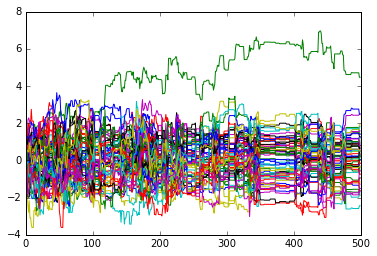

In [15]:
plt.plot(samples)

In [16]:
l = []
for s in samples:
    m.set_state(s)
    l.append(m.kern.matern32.lengthscales._array.copy())
    

In [17]:
l = np.vstack(l)

(array([  5.,   3.,   4.,   5.,  10.,  14.,   2.,  14.,  12.,  14.,  27.,
         26.,  14.,  43.,  28.,  34.,  28.,  15.,  24.,  15.,  35.,  13.,
         22.,   2.,  28.,  16.,   2.,  17.,   6.,   1.,   2.,   8.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   9.]),
 array([ 0.10150057,  0.10627615,  0.11105173,  0.11582731,  0.12060289,
         0.12537846,  0.13015404,  0.13492962,  0.1397052 ,  0.14448078,
         0.14925636,  0.15403194,  0.15880752,  0.1635831 ,  0.16835868,
         0.17313426,  0.17790983,  0.18268541,  0.18746099,  0.19223657,
         0.19701215,  0.20178773,  0.20656331,  0.21133889,  0.21611447,
         0.22089005,  0.22566563,  0.23044121,  0.23521678,  0.23999236,
         0.24476794,  0.24954352,  0.2543191 ,  0.25909468,  0.26387026,
         0.26864584,  0.27342142,  0.278197  ,  0.28297258,  0.28774815,
         0.29252373,  0.29729931,  0.30207489,  0.30685047,  0.31162605,
 

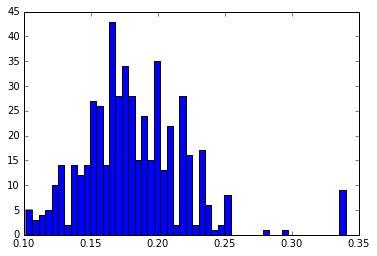

In [18]:
plt.hist(l, 50)